# San Francisco Rental Prices Dashboard

In [21]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
%matplotlib inline
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv

In [22]:
#MAPBOX_TOKEN 
load_dotenv()
mapbox_token = os.getenv("MAPBOX_TOKEN")
px.set_mapbox_access_token(mapbox_token)

In [23]:
sfo_data = pd.read_csv("Data/sfo_neighborhoods_census_data.csv", index_col="year")
coordinates_df = pd.read_csv("Data/neighborhoods_coordinates.csv")

In [24]:
neighborhood_mean_df = sfo_data.groupby(['neighborhood']).mean().reset_index()

In [25]:
combined_df = pd.concat([neighborhood_mean_df, coordinates_df], axis='columns', join='inner')
combined_df = combined_df.dropna()
combined_df.drop(columns=['Neighborhood'], inplace=True)

In [26]:
# Define Panel Visualization Functions
def housing_units_per_year():
    """Housing Units Per Year."""
    housing_units = sfo_data.groupby(['year'])['housing_units']
    housing_units_mean = housing_units.mean()
    housing_units_min = housing_units_mean.min()
    housing_units_max = housing_units_mean.max()
    housing_units_std = housing_units_mean.std()
    housing_units_mean.plot.bar(
        figsize=(8,8), 
        x='Year', 
        y='Housing Units',
        title='Housing Units in San-Francisco from 2010 to 2016')
    plt.ylim([housing_units_min-housing_units_std,housing_units_max+housing_units_std])
    return plt

def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    sfo_avg_price_rent_df = sfo_data[['sale_price_sqr_foot','gross_rent']].groupby(['year'])['sale_price_sqr_foot','gross_rent'].mean()
    gross_plot = sfo_avg_price_rent_df.reset_index().plot(
        x='year', 
        y='gross_rent', 
        title='Average Gross Rent by Year',
        color='red'
    )
    gross_plot.set_ylabel("Gross Rent")
    return gross_plot

def average_sales_price():
    """Average Sales Price Per Year."""
    sfo_avg_price_rent_df = sfo_data[['sale_price_sqr_foot','gross_rent']].groupby(['year'])['sale_price_sqr_foot','gross_rent'].mean()
    price_plot = sfo_avg_price_rent_df.reset_index().plot(
        x='year', 
        y='sale_price_sqr_foot', 
        title='Average Price per SqFt by Year',
        color='purple')
    price_plot.set_ylabel("Price per SqFt")
    return price_plot

def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    sfo_avg_price_by_neighborhood = sfo_data.groupby(['year','neighborhood']).mean().reset_index()
    plot = sfo_avg_price_by_neighborhood.hvplot.line(
        "year",
        "sale_price_sqr_foot",
        xlabel= "Year",
        ylabel="Avg. Sale Price per Square Foot",
        groupby="neighborhood",
    )
    return plot

def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""
    top10_neighborhoods = sfo_data.groupby(['neighborhood']).mean()
    top10_neighborhoods.sort_values(['sale_price_sqr_foot'], ascending=False, inplace=True)
    top10_neighborhoods = top10_neighborhoods.reset_index().head(10)
    top10_plot = top10_neighborhoods.hvplot.bar(
        "neighborhood",
        "sale_price_sqr_foot",
        title="Top 10 Expensive Neighborhoods in SFO",
        xlabel="Neighborhood",
        ylabel="Avg. Sale Price per Square Foot",
        height=500,
        rot=90
    ).opts(yformatter="%.0f")
    return top10_plot


def most_expensive_neighborhoods_rent_sales():
    """Comparison of Rent and Sales Prices of Most Expensive Neighborhoods."""   
    sfo_avg_price_by_neighborhood = sfo_data.groupby(['year','neighborhood']).mean().reset_index()
    sfo_avg_price_by_neighborhood_plot = sfo_avg_price_by_neighborhood.hvplot.bar(
        x='year', 
        y=['sale_price_sqr_foot', 'gross_rent'], 
        xlabel='Year', 
        ylabel='Avg price, Gross rent', 
        groupby='neighborhood', 
        rot=90, 
        width=700, 
        height=500
    ).opts(yformatter="%.0f")
    return sfo_avg_price_by_neighborhood_plot  
    
def parallel_coordinates():
    """Parallel Coordinates Plot."""
    sfo_avg_price_by_neighborhood = sfo_data.groupby(['year','neighborhood']).mean().reset_index()
    top10_neighborhoods = sfo_data.groupby(['neighborhood']).mean()
    top10_neighborhoods.sort_values(['sale_price_sqr_foot'], ascending=False, inplace=True)
    top10_neighborhoods = top10_neighborhoods.reset_index().head(10)
    df_expensive_neighborhoods_per_year = sfo_avg_price_by_neighborhood[sfo_avg_price_by_neighborhood["neighborhood"].isin(top10_neighborhoods["neighborhood"])]
    coor_plot = px.parallel_coordinates(
        top10_neighborhoods, 
        color='sale_price_sqr_foot',
        title = 'Parallel Coordinates Plot of Most Expensive Neighborhoods in San Francisco per Year'
    )
    return coor_plot  

def parallel_categories():
    """Parallel Categories Plot."""
    sfo_avg_price_by_neighborhood = sfo_data.groupby(['year','neighborhood']).mean().reset_index()
    top10_neighborhoods = sfo_data.groupby(['neighborhood']).mean()
    top10_neighborhoods.sort_values(['sale_price_sqr_foot'], ascending=False, inplace=True)
    top10_neighborhoods = top10_neighborhoods.reset_index().head(10)
    df_expensive_neighborhoods_per_year = sfo_avg_price_by_neighborhood[sfo_avg_price_by_neighborhood["neighborhood"].isin(top10_neighborhoods["neighborhood"])]
    cat_plot = px.parallel_categories(
        top10_neighborhoods,
        dimensions=['neighborhood', 'sale_price_sqr_foot', 'housing_units', 'gross_rent'],
        color='sale_price_sqr_foot',
        color_continuous_scale=px.colors.sequential.Inferno,
        labels={
            'neighborhood': 'neighborhood',
            'sale_price_sqr_foot': 'sale_price_sqr_foot',
            'housing_units': 'housing_units',
            'gross_rent': 'gross_rent'
        },
    )
    return cat_plot

def neighborhood_map():
    """Neighborhood Map."""
    # Create a scatter mapbox to analyze neighborhood info
    map_plot = px.scatter_mapbox(
        combined_df,
        lat="Lat",
        lon="Lon",
        size="sale_price_sqr_foot",
        color="gross_rent",
        color_continuous_scale=px.colors.cyclical.IceFire,
        hover_name="neighborhood",
        title="Averange Sale Price Per Square Foot and Gross Rent in San Francisco",
        zoom=11
    )
    return map_plot


def sunburst():
    """Sunburst Plot."""
    
    sfo_avg_price_by_neighborhood = sfo_data.groupby(['year','neighborhood']).mean().reset_index()
    top10_neighborhoods = sfo_data.groupby(['neighborhood']).mean()
    top10_neighborhoods.sort_values(['sale_price_sqr_foot'], ascending=False, inplace=True)
    top10_neighborhoods = top10_neighborhoods.reset_index().head(10)
    df_expensive_neighborhoods_per_year = sfo_avg_price_by_neighborhood[sfo_avg_price_by_neighborhood["neighborhood"].isin(top10_neighborhoods["neighborhood"])]
    plot = px.sunburst(
        df_expensive_neighborhoods_per_year, 
        path=['year','neighborhood'], 
        color='gross_rent', 
        color_continuous_scale='RdBu',
        title = 'Costs Analysis of Most Expensive Neighborhoods in San Francisco per Year'
    )
    return plot
    

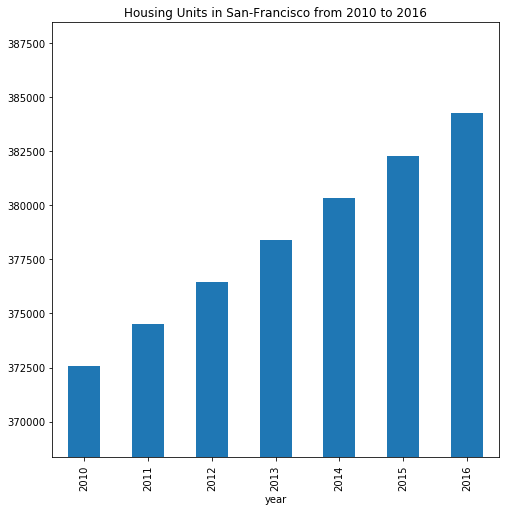

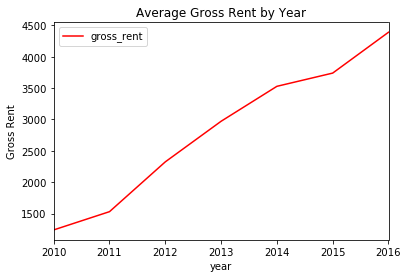

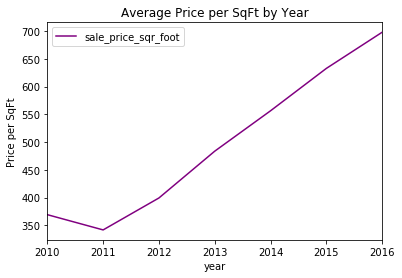

In [34]:
# Create a Title for the Dashboard
welcome_column = pn.Column("#### This Dashboard presents the historical analysis of realestate sale prices, gross rents based on the neighborhoods of San Fancisco, California from 2010 to 2016", neighborhood_map())
row_analysis = pn.Row(housing_units_per_year(),average_gross_rent(),average_sales_price()) 
market_analysis = pn.Column("## Yearly Market Analysis",row_analysis)
neighborhood_analysis = pn.Column("## Neighborhood Analysis",  average_price_by_neighborhood(), top_most_expensive_neighborhoods(), most_expensive_neighborhoods_rent_sales())
parallel_plot_analysis = pn.Column("## Parallel Plot Analysis", parallel_categories(), parallel_coordinates())
sunburst_plot_analysis = pn.Column("## Sunburst Plot Analysis", sunburst())

dashboard = pn.Tabs(
    (
        "Welcome",
        welcome_column
    ),
    (
        "Market Analysis",
        market_analysis
    ),
    (
        "Neighborhood Analysis",
        neighborhood_analysis
    ),
    (
        "Parallel Plot Analysis",
        parallel_plot_analysis
    ),
    (
        "Sunburst Plot Analysis",
        sunburst_plot_analysis
    )
)

In [35]:
dashboard.servable()

Tabs
    [0] Column
        [0] Markdown(str)
        [1] Plotly(Figure)
    [1] Column
        [0] Markdown(str)
        [1] Row
            [0] Str(module)
            [1] Str(AxesSubplot)
            [2] Str(AxesSubplot)
    [2] Column
        [0] Markdown(str)
        [1] Row
            [0] HoloViews(DynamicMap)
            [1] Column
                [0] WidgetBox
                    [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                [1] VSpacer()
        [2] HoloViews(Bars)
        [3] Row
            [0] HoloViews(DynamicMap)
            [1] Column
                [0] WidgetBox
                    [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                [1] VSpacer()
    [3] Column
        [0] Markdown(str)
        [1] Plotly(Figure)
        [2] Plotly(Figure)
    [4] Column
        [0] Markdown(str)
        [1] Plotly(Figure)

<module 'matplotlib.pyplot' from '/Users/syedahasan/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/matplotlib/pyplot.py'>

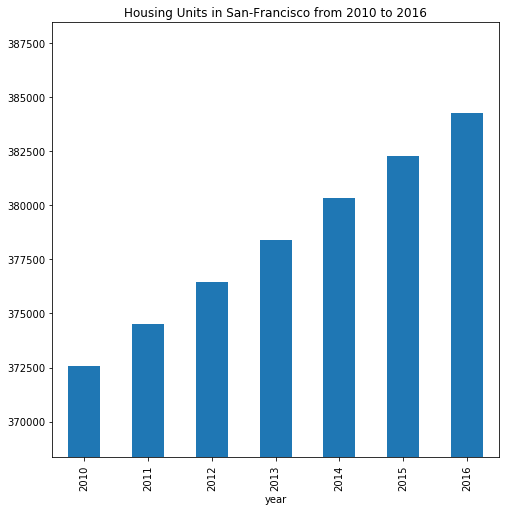

In [31]:
 housing_units_per_year()

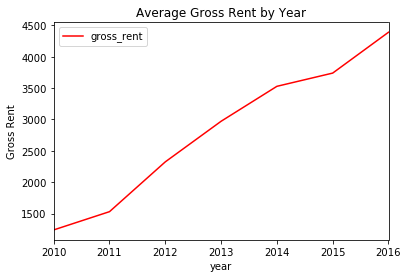

In [32]:
 average_gross_rent() 

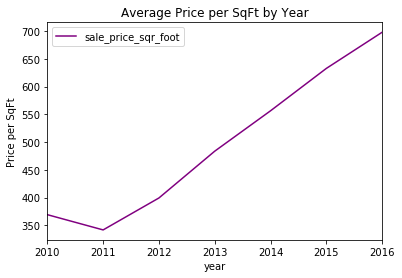

In [33]:
 average_sales_price()